## 사용할 패키지

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import datetime

## 데이터 불러오기

In [2]:
site = pd.read_csv('data/site_info.csv')
energy = pd.read_csv('data/energy.csv')
dangjin_fcst = pd.read_csv('data/dangjin_fcst_wind_time.csv')
ulsan_fcst = pd.read_csv('data/ulsan_fcst_wind_time.csv')

In [3]:
site = pd.read_csv('data/site_info.csv')
energy = pd.read_csv('data/add_energy.csv')
dangjin_fcst = pd.read_csv('data/add_dangjin_fcst_rev.csv')
ulsan_fcst = pd.read_csv('data/add_ulsan_fcst_rev.csv')

In [4]:
energy

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2015-01-01 01:00:00,NaN,0.0,0.0,0.0
1,2015-01-01 02:00:00,NaN,0.0,0.0,0.0
2,2015-01-01 03:00:00,NaN,0.0,0.0,0.0
3,2015-01-01 04:00:00,NaN,0.0,0.0,0.0
4,2015-01-01 05:00:00,NaN,0.0,0.0,0.0
...,...,...,...,...,...
53347,2021-01-31 20:00:00,0.0,0.0,0.0,0.0
53348,2021-01-31 21:00:00,0.0,0.0,0.0,0.0
53349,2021-01-31 22:00:00,0.0,0.0,0.0,0.0
53350,2021-01-31 23:00:00,0.0,0.0,0.0,0.0


In [5]:
dangjin_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2015-01-01 01:00:00,-4.200000,59.333333,14.800000,319.333333,3.0
1,2015-01-01 02:00:00,-4.800000,59.666667,15.000000,321.666667,3.0
2,2015-01-01 03:00:00,-5.400000,60.000000,15.200000,324.000000,3.0
3,2015-01-01 04:00:00,-5.400000,60.000000,15.200000,325.666667,3.0
4,2015-01-01 05:00:00,-5.400000,60.000000,15.200000,327.333333,3.0
...,...,...,...,...,...,...
54019,2021-02-28 20:00:00,7.666667,66.666667,1.133333,124.333333,4.0
54020,2021-02-28 21:00:00,7.000000,70.000000,1.300000,18.000000,4.0
54021,2021-02-28 22:00:00,6.833333,71.666667,1.533333,20.166667,4.0
54022,2021-02-28 23:00:00,6.666667,73.333333,1.766667,22.333333,4.0


In [6]:
ulsan_fcst.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2015-01-01 01:00:00,-1.633333,44.000000,7.866667,289.0,1.666667
1,2015-01-01 02:00:00,-2.216667,45.000000,8.033333,287.5,1.833333
2,2015-01-01 03:00:00,-2.800000,46.000000,8.200000,286.0,2.000000
3,2015-01-01 04:00:00,-3.133333,45.333333,8.233333,288.0,2.000000
4,2015-01-01 05:00:00,-3.466667,44.666667,8.266667,290.0,2.000000


기상 예보는 전날 14시(오후 2시) 예보를 선형보간하여 사용하였습니다.

※ 기상 예보 전치리 과정 : https://dacon.io/competitions/official/235720/codeshare/2499?page=1&dtype=recent

In [7]:
def transform_wind_to_vector(df_):
    df = df_.copy()

    wv = df['WindSpeed']

    # Convert to radians.
    wd_rad = df['WindDirection']*np.pi / 180

    # Calculate the wind x and y components.
    df['Wind_X'] = wv*np.cos(wd_rad)
    df['Wind_Y'] = wv*np.sin(wd_rad)
    
    return df

In [8]:
def transform_datetime_to_signal(df_):
    df = df_.copy()
    date_time = pd.to_datetime(df['Forecast_time'], format='%Y.%m.%d %H:%M')
    timestamp_s = date_time.map(datetime.datetime.timestamp)

    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

    return df

In [9]:
dangjin_fcst = transform_wind_to_vector(dangjin_fcst)
dangjin_fcst = transform_datetime_to_signal(dangjin_fcst)

In [10]:
dangjin_fcst.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos
0,2015-01-01 01:00:00,-4.2,59.333333,14.8,319.333333,3.0,11.226001,-9.644527,-0.866025,-5.000000e-01,-0.004229,0.999991
1,2015-01-01 02:00:00,-4.8,59.666667,15.0,321.666667,3.0,11.766235,-9.303532,-0.965926,-2.588190e-01,-0.003512,0.999994
2,2015-01-01 03:00:00,-5.4,60.000000,15.2,324.000000,3.0,12.297058,-8.934336,-1.000000,-1.075621e-11,-0.002795,0.999996
3,2015-01-01 04:00:00,-5.4,60.000000,15.2,325.666667,3.0,12.551709,-8.572900,-0.965926,2.588190e-01,-0.002079,0.999998
4,2015-01-01 05:00:00,-5.4,60.000000,15.2,327.333333,3.0,12.795739,-8.204210,-0.866025,5.000000e-01,-0.001362,0.999999


In [11]:
ulsan_fcst = transform_wind_to_vector(ulsan_fcst)
ulsan_fcst = transform_datetime_to_signal(ulsan_fcst)

In [12]:
ulsan_fcst.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos
0,2015-01-01 01:00:00,-1.633333,44.000000,7.866667,289.0,1.666667,2.561136,-7.438079,-0.866025,-5.000000e-01,-0.004229,0.999991
1,2015-01-01 02:00:00,-2.216667,45.000000,8.033333,287.5,1.833333,2.415670,-7.661526,-0.965926,-2.588190e-01,-0.003512,0.999994
2,2015-01-01 03:00:00,-2.800000,46.000000,8.200000,286.0,2.000000,2.260226,-7.882346,-1.000000,-1.075621e-11,-0.002795,0.999996
3,2015-01-01 04:00:00,-3.133333,45.333333,8.233333,288.0,2.000000,2.544240,-7.830365,-0.965926,2.588190e-01,-0.002079,0.999998
4,2015-01-01 05:00:00,-3.466667,44.666667,8.266667,290.0,2.000000,2.827367,-7.768126,-0.866025,5.000000e-01,-0.001362,0.999999


In [13]:
dangjin_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos
0,2015-01-01 01:00:00,-4.200000,59.333333,14.800000,319.333333,3.0,11.226001,-9.644527,-8.660254e-01,-5.000000e-01,-0.004229,0.999991
1,2015-01-01 02:00:00,-4.800000,59.666667,15.000000,321.666667,3.0,11.766235,-9.303532,-9.659258e-01,-2.588190e-01,-0.003512,0.999994
2,2015-01-01 03:00:00,-5.400000,60.000000,15.200000,324.000000,3.0,12.297058,-8.934336,-1.000000e+00,-1.075621e-11,-0.002795,0.999996
3,2015-01-01 04:00:00,-5.400000,60.000000,15.200000,325.666667,3.0,12.551709,-8.572900,-9.659258e-01,2.588190e-01,-0.002079,0.999998
4,2015-01-01 05:00:00,-5.400000,60.000000,15.200000,327.333333,3.0,12.795739,-8.204210,-8.660254e-01,5.000000e-01,-0.001362,0.999999
...,...,...,...,...,...,...,...,...,...,...,...,...
54019,2021-02-28 20:00:00,7.666667,66.666667,1.133333,124.333333,4.0,-0.639207,0.935873,2.588190e-01,-9.659258e-01,0.850285,0.526323
54020,2021-02-28 21:00:00,7.000000,70.000000,1.300000,18.000000,4.0,1.236373,0.401722,9.206058e-12,-1.000000e+00,0.850662,0.525713
54021,2021-02-28 22:00:00,6.833333,71.666667,1.533333,20.166667,4.0,1.439330,0.528620,-2.588190e-01,-9.659258e-01,0.851039,0.525103
54022,2021-02-28 23:00:00,6.666667,73.333333,1.766667,22.333333,4.0,1.634147,0.671323,-5.000000e-01,-8.660254e-01,0.851415,0.524493


## 일사량 추가하기

In [14]:
def sind(degree):
    return np.sin(np.radians(degree))
def cosd(degree):
    return np.cos(np.radians(degree))
def arcsind(degree):
    return np.arcsin(np.radians(degree))
def arccosd(degree):
    return np.arccos(np.radians(degree))

In [15]:
def sunDeclination(day):                                    # 태양 적위
    return 23.45 * sind((360 / 365) * (day - 81))

In [16]:
def sunAltitude(latitude, declination, hour):               # 태양 고도
    l, d, H = latitude, declination, hour
    h = (sind(l) * sind(d)) + (cosd(l) * cosd(d) * cosd(H))
    h = np.degrees(np.arcsin(h))
    return h

In [17]:
def sunRiseSet(latitude, declination, longitude):           # 일출 일몰 시간
    lat, d, long = latitude, declination, longitude
    b = (-1 * sind(lat) * sind(d)) / (cosd(lat) * cosd(d))
    b = np.degrees(np.arccos(b)) / 15
    d = longitude / 15                                      # 경도에 따른 시간 보정 (GMT +9:00는 경도 135도) 
    r = 0.00625                                             # refraction_rate, 굴절에 따른 시간 보정 (약 9분)
    sunrise = 12 - b - d + r
    sunset = 12 + b - d - r
    return sunrise, sunset

In [18]:
def directInsolation(altitude):                             # 직사 일사량
    am = 1/cosd(90 - altitude)                              # airmass
    I = 1.353 * 0.7 ** (am ** 0.678)                        # direct insolation
    return I

In [19]:
tokyo_longitude = 135.0

dangjin_latitude = float(site.loc[site['Id'] == '당진태양광', 'Latitude'])
dangjin_longitude = float(site.loc[site['Id'] == '당진태양광', 'Longitude'])

ulsan_latitude = float(site.loc[site['Id'] == '울산태양광', 'Latitude'])
ulsan_longitude = float(site.loc[site['Id'] == '울산태양광', 'Longitude'])

dangjin_latitude, dangjin_longitude, ulsan_latitude, ulsan_longitude

(37.0507527, 126.5102993, 35.47765089999999, 129.380778)

In [20]:
dangjin_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos
0,2015-01-01 01:00:00,-4.200000,59.333333,14.800000,319.333333,3.0,11.226001,-9.644527,-8.660254e-01,-5.000000e-01,-0.004229,0.999991
1,2015-01-01 02:00:00,-4.800000,59.666667,15.000000,321.666667,3.0,11.766235,-9.303532,-9.659258e-01,-2.588190e-01,-0.003512,0.999994
2,2015-01-01 03:00:00,-5.400000,60.000000,15.200000,324.000000,3.0,12.297058,-8.934336,-1.000000e+00,-1.075621e-11,-0.002795,0.999996
3,2015-01-01 04:00:00,-5.400000,60.000000,15.200000,325.666667,3.0,12.551709,-8.572900,-9.659258e-01,2.588190e-01,-0.002079,0.999998
4,2015-01-01 05:00:00,-5.400000,60.000000,15.200000,327.333333,3.0,12.795739,-8.204210,-8.660254e-01,5.000000e-01,-0.001362,0.999999
...,...,...,...,...,...,...,...,...,...,...,...,...
54019,2021-02-28 20:00:00,7.666667,66.666667,1.133333,124.333333,4.0,-0.639207,0.935873,2.588190e-01,-9.659258e-01,0.850285,0.526323
54020,2021-02-28 21:00:00,7.000000,70.000000,1.300000,18.000000,4.0,1.236373,0.401722,9.206058e-12,-1.000000e+00,0.850662,0.525713
54021,2021-02-28 22:00:00,6.833333,71.666667,1.533333,20.166667,4.0,1.439330,0.528620,-2.588190e-01,-9.659258e-01,0.851039,0.525103
54022,2021-02-28 23:00:00,6.666667,73.333333,1.766667,22.333333,4.0,1.634147,0.671323,-5.000000e-01,-8.660254e-01,0.851415,0.524493


In [21]:
dangjin_insola = pd.DataFrame(data=[sunDeclination(i//24) for i in range(365 * 24 * 7 + 24 + 23)], columns=['declination'])

dangjin_insola['sunrise'], dangjin_insola['sunset'] = sunRiseSet(dangjin_latitude, dangjin_insola['declination'], dangjin_longitude - tokyo_longitude)

# (00시는 -180°, 06시는 -90°, 12시는 0°, 18시는 +90°, 24시는 +180°)
dangjin_insola['altitude'] = sunAltitude(dangjin_latitude, dangjin_insola['declination'], [(i % 24) * 15 - 180 for i in range(365 * 24 * 7 + 24 + 23)]) 
dangjin_insola.loc[dangjin_insola['altitude'] < 0, 'altitude'] = 0

dangjin_insola['Insolation'] = directInsolation(dangjin_insola['altitude'])

dangjin_insola['Forecast_time'] = pd.date_range('2015-01-01 01:00:00', '2021-12-31 23:00:00', freq='H')

start = '2015-01-01 01:00:00'
end = '2021-03-01 00:00:00'

start_idx = dangjin_insola[dangjin_insola['Forecast_time']==start].index[0]
end_idx = dangjin_insola[dangjin_insola['Forecast_time']==end].index[0]

dangjin_insola = dangjin_insola.loc[start_idx:end_idx, :].copy()
dangjin_insola.index = range(dangjin_insola.shape[0])

dangjin_insola['Forecast_time'] = dangjin_insola['Forecast_time'].astype(str)

dangjin_insola

,declination,sunrise,sunset,altitude,Insolation,Forecast_time
0,-23.085911,7.823650,17.308310,0.0,0.0,2015-01-01 01:00:00
1,-23.085911,7.823650,17.308310,0.0,0.0,2015-01-01 02:00:00
2,-23.085911,7.823650,17.308310,0.0,0.0,2015-01-01 03:00:00
3,-23.085911,7.823650,17.308310,0.0,0.0,2015-01-01 04:00:00
4,-23.085911,7.823650,17.308310,0.0,0.0,2015-01-01 05:00:00
...,...,...,...,...,...,...
54019,-8.293705,6.993442,18.138518,0.0,0.0,2021-02-28 20:00:00
54020,-8.293705,6.993442,18.138518,0.0,0.0,2021-02-28 21:00:00
54021,-8.293705,6.993442,18.138518,0.0,0.0,2021-02-28 22:00:00
54022,-8.293705,6.993442,18.138518,0.0,0.0,2021-02-28 23:00:00


In [22]:
ulsan_insola = pd.DataFrame(data=[sunDeclination(i//24) for i in range(365 * 24 * 7 + 24 + 23)], columns=['declination'])

ulsan_insola['sunrise'], dangjin_insola['sunset'] = sunRiseSet(ulsan_latitude, ulsan_insola['declination'], ulsan_longitude - tokyo_longitude)

# (00시는 -180°, 06시는 -90°, 12시는 0°, 18시는 +90°, 24시는 +180°)
ulsan_insola['altitude'] = sunAltitude(ulsan_latitude, ulsan_insola['declination'], [(i % 24) * 15 - 180 for i in range(365 * 24 * 7 + 24 + 23)]) 
ulsan_insola.loc[ulsan_insola['altitude'] < 0, 'altitude'] = 0

ulsan_insola['Insolation'] = directInsolation(ulsan_insola['altitude'])

ulsan_insola['Forecast_time'] = pd.date_range('2015-01-01 01:00:00', '2021-12-31 23:00:00', freq='H')

start = '2015-01-01 01:00:00'
end = '2021-03-01 00:00:00'

start_idx = ulsan_insola[ulsan_insola['Forecast_time']==start].index[0]
end_idx = ulsan_insola[ulsan_insola['Forecast_time']==end].index[0]

ulsan_insola = ulsan_insola.loc[start_idx:end_idx, :].copy()
ulsan_insola.index = range(ulsan_insola.shape[0])

ulsan_insola['Forecast_time'] = ulsan_insola['Forecast_time'].astype(str)

ulsan_insola

,declination,sunrise,altitude,Insolation,Forecast_time
0,-23.085911,7.559879,0.0,0.0,2015-01-01 01:00:00
1,-23.085911,7.559879,0.0,0.0,2015-01-01 02:00:00
2,-23.085911,7.559879,0.0,0.0,2015-01-01 03:00:00
3,-23.085911,7.559879,0.0,0.0,2015-01-01 04:00:00
4,-23.085911,7.559879,0.0,0.0,2015-01-01 05:00:00
...,...,...,...,...,...
54019,-8.293705,6.778422,0.0,0.0,2021-02-28 20:00:00
54020,-8.293705,6.778422,0.0,0.0,2021-02-28 21:00:00
54021,-8.293705,6.778422,0.0,0.0,2021-02-28 22:00:00
54022,-8.293705,6.778422,0.0,0.0,2021-02-28 23:00:00


In [23]:
dangjin_fcst = pd.merge(dangjin_fcst, dangjin_insola, on='Forecast_time', how='outer')
ulsan_fcst = pd.merge(ulsan_fcst, ulsan_insola, on='Forecast_time', how='outer')
# dangjin_fcst
# ulsan_fcst

In [24]:
dangjin_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos,declination,sunrise,sunset,altitude,Insolation
0,2015-01-01 01:00:00,-4.200000,59.333333,14.800000,319.333333,3.0,11.226001,-9.644527,-8.660254e-01,-5.000000e-01,-0.004229,0.999991,-23.085911,7.823650,17.189351,0.0,0.0
1,2015-01-01 02:00:00,-4.800000,59.666667,15.000000,321.666667,3.0,11.766235,-9.303532,-9.659258e-01,-2.588190e-01,-0.003512,0.999994,-23.085911,7.823650,17.189351,0.0,0.0
2,2015-01-01 03:00:00,-5.400000,60.000000,15.200000,324.000000,3.0,12.297058,-8.934336,-1.000000e+00,-1.075621e-11,-0.002795,0.999996,-23.085911,7.823650,17.189351,0.0,0.0
3,2015-01-01 04:00:00,-5.400000,60.000000,15.200000,325.666667,3.0,12.551709,-8.572900,-9.659258e-01,2.588190e-01,-0.002079,0.999998,-23.085911,7.823650,17.189351,0.0,0.0
4,2015-01-01 05:00:00,-5.400000,60.000000,15.200000,327.333333,3.0,12.795739,-8.204210,-8.660254e-01,5.000000e-01,-0.001362,0.999999,-23.085911,7.823650,17.189351,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54019,2021-02-28 20:00:00,7.666667,66.666667,1.133333,124.333333,4.0,-0.639207,0.935873,2.588190e-01,-9.659258e-01,0.850285,0.526323,-8.293705,6.993442,17.970808,0.0,0.0
54020,2021-02-28 21:00:00,7.000000,70.000000,1.300000,18.000000,4.0,1.236373,0.401722,9.206058e-12,-1.000000e+00,0.850662,0.525713,-8.293705,6.993442,17.970808,0.0,0.0
54021,2021-02-28 22:00:00,6.833333,71.666667,1.533333,20.166667,4.0,1.439330,0.528620,-2.588190e-01,-9.659258e-01,0.851039,0.525103,-8.293705,6.993442,17.970808,0.0,0.0
54022,2021-02-28 23:00:00,6.666667,73.333333,1.766667,22.333333,4.0,1.634147,0.671323,-5.000000e-01,-8.660254e-01,0.851415,0.524493,-8.293705,6.993442,17.970808,0.0,0.0


In [25]:
ulsan_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos,declination,sunrise,altitude,Insolation
0,2015-01-01 01:00:00,-1.633333,44.000000,7.866667,289.000000,1.666667,2.561136,-7.438079,-8.660254e-01,-5.000000e-01,-0.004229,0.999991,-23.085911,7.559879,0.0,0.0
1,2015-01-01 02:00:00,-2.216667,45.000000,8.033333,287.500000,1.833333,2.415670,-7.661526,-9.659258e-01,-2.588190e-01,-0.003512,0.999994,-23.085911,7.559879,0.0,0.0
2,2015-01-01 03:00:00,-2.800000,46.000000,8.200000,286.000000,2.000000,2.260226,-7.882346,-1.000000e+00,-1.075621e-11,-0.002795,0.999996,-23.085911,7.559879,0.0,0.0
3,2015-01-01 04:00:00,-3.133333,45.333333,8.233333,288.000000,2.000000,2.544240,-7.830365,-9.659258e-01,2.588190e-01,-0.002079,0.999998,-23.085911,7.559879,0.0,0.0
4,2015-01-01 05:00:00,-3.466667,44.666667,8.266667,290.000000,2.000000,2.827367,-7.768126,-8.660254e-01,5.000000e-01,-0.001362,0.999999,-23.085911,7.559879,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54019,2021-02-28 20:00:00,14.000000,73.333333,3.900000,155.333333,4.000000,-3.544129,1.627620,2.588190e-01,-9.659258e-01,0.850285,0.526323,-8.293705,6.778422,0.0,0.0
54020,2021-02-28 21:00:00,14.000000,75.000000,4.300000,154.000000,4.000000,-3.864814,1.884996,9.206058e-12,-1.000000e+00,0.850662,0.525713,-8.293705,6.778422,0.0,0.0
54021,2021-02-28 22:00:00,13.833333,76.666667,4.066667,157.666667,4.000000,-3.761621,1.545310,-2.588190e-01,-9.659258e-01,0.851039,0.525103,-8.293705,6.778422,0.0,0.0
54022,2021-02-28 23:00:00,13.666667,78.333333,3.833333,161.333333,4.000000,-3.631687,1.226904,-5.000000e-01,-8.660254e-01,0.851415,0.524493,-8.293705,6.778422,0.0,0.0


In [26]:
dangjin_fcst.to_csv("data/add_data_dangjin.csv", index=False)
ulsan_fcst.to_csv("data/add_data_ulsan.csv", index=False)

## 학습 데이터 전처리

In [106]:
def add_train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df
    energy.index = range(energy.shape[0])
    if target == 'dangjin_floating':
        energy = energy_df[26304:]
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.iloc[:-672]
    fcst.index = range(fcst.shape[0])
    if target == 'dangjin_floating':
        fcst = fcst_df.iloc[26304:-672]
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    # feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    feature_df = concat_df[[#'year', 'month', 'day', 'hour', 
                            'Year sin', 'Year cos', 'Day sin', 'Day cos',
                            'Temperature', 'Humidity', 
                            'WindSpeed', 'WindDirection',
                            'Wind_X', 'Wind_Y',
                            'Insolation',
                            'Cloud', target]]
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*30]
    val_df = feature_df.iloc[-24*30:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    #train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_x = train_df.loc[:, :'Cloud'].to_numpy()
    train_y = train_df[target].to_numpy()
    
    #val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_x = val_df.loc[:, :'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

## LightGBM Custom Metric

In [77]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

## Validation Metric

In [78]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

## LightGBM Hyperparameter

In [79]:
params = {
    'learning_rate': 0.01,
    'num_iterations': 10000,
    'max_depth': -1, # 최대 깊이 트리를 만듬
#     'max_depth': 16,
    #'num_leaves': ,
    'boosting': 'gbdt',
    'bagging_freq': 2,
    'bagging_fraction': 0.7,
    'feature_fraction': 0.8,
    'objective': 'regression',
    'metric':'mse',
    'seed':42
}

### 당진수상태양광 예측 모델 학습

In [107]:
train_x, train_y, val_x, val_y = add_train_datast(energy, dangjin_fcst, target='dangjin_floating')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

D:\Anaconda\envs\data_engeneering\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 12979, number of used features: 12
[LightGBM] [Info] Start training from score 248.670468
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[259]	valid_0's l2: 4840.9	valid_0's score: 7.99771


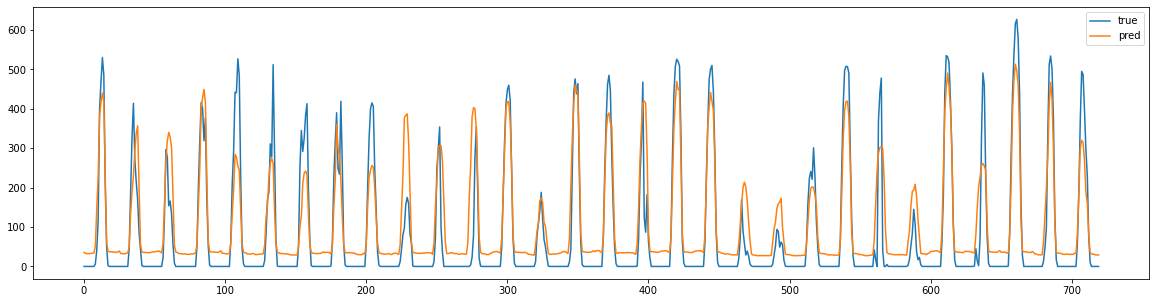

CV Score :  7.997711016689377


In [108]:
pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

### 당진자재창고태양광 예측 모델 학습

In [109]:
train_x, train_y, val_x, val_y = add_train_datast(energy, dangjin_fcst, target='dangjin_warehouse')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 700
dangjin_warehouse_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

D:\Anaconda\envs\data_engeneering\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2740
[LightGBM] [Info] Number of data points in the train set: 25267, number of used features: 12
[LightGBM] [Info] Start training from score 198.661179
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	valid_0's l2: 3730.87	valid_0's score: 9.67561


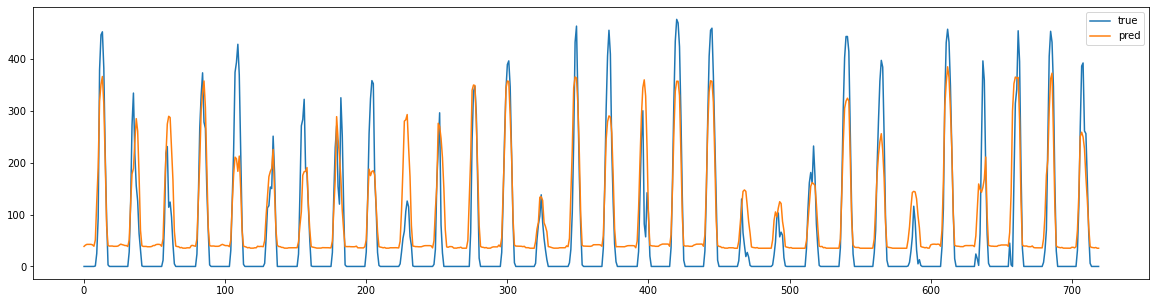

CV Score :  9.675607984649227


In [110]:
pred = dangjin_warehouse_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

### 당진태양광 예측 모델 학습

In [113]:
train_x, train_y, val_x, val_y = add_train_datast(energy, dangjin_fcst, target='dangjin')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

D:\Anaconda\envs\data_engeneering\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2743
[LightGBM] [Info] Number of data points in the train set: 23859, number of used features: 12
[LightGBM] [Info] Start training from score 309.862861
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[201]	valid_0's l2: 9361.63	valid_0's score: 10.6562


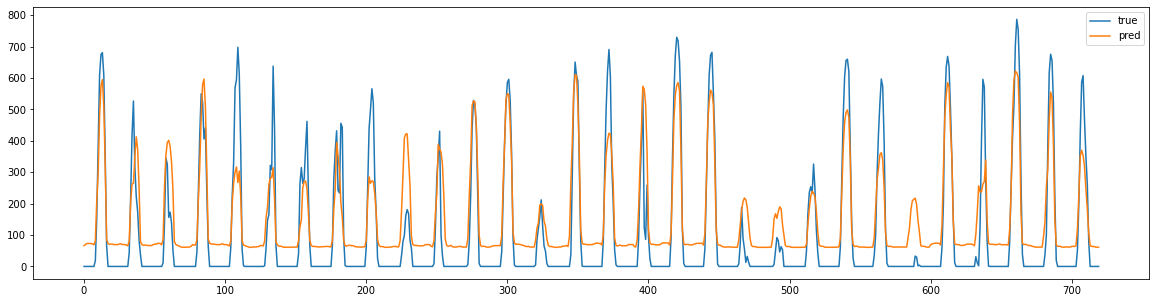

CV Score :  10.656221093367195


In [114]:
pred = dangjin_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

### 울산태양광 예측 모델 학습

In [115]:
train_x, train_y, val_x, val_y = add_train_datast(energy, ulsan_fcst, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 500
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

D:\Anaconda\envs\data_engeneering\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3013
[LightGBM] [Info] Number of data points in the train set: 24485, number of used features: 12
[LightGBM] [Info] Start training from score 138.702879
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l2: 676.861	valid_0's score: 5.9408
[1000]	valid_0's l2: 646.777	valid_0's score: 5.69796
Early stopping, best iteration is:
[1156]	valid_0's l2: 642.265	valid_0's score: 5.61556


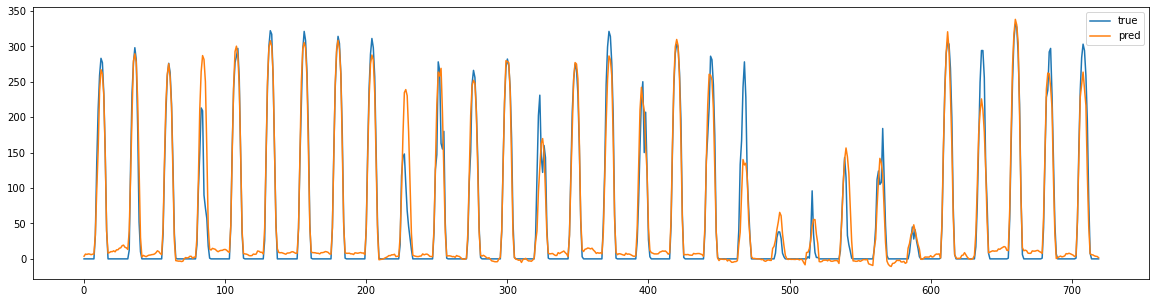

CV Score :  5.6155648493646115


In [116]:
pred = ulsan_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

## 테스트 데이터 전처리

In [120]:
def add_test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    #test_df = test_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    test_df = test_df[[ #'year', 'month', 'day', 'hour', 
                        'Year sin', 'Year cos', 'Day sin', 'Day cos',
                        'Temperature', 'Humidity', 
                        'WindSpeed', 'WindDirection',
                        'Wind_X', 'Wind_Y',
                        'Insolation',
                        'Cloud']]
    
    test_x = test_df.to_numpy()
    
    return test_x

In [123]:
dangjin_test = add_test_datast(dangjin_fcst)
ulsan_test = add_test_datast(ulsan_fcst)

## 각 발전소 발전량 추론

In [124]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

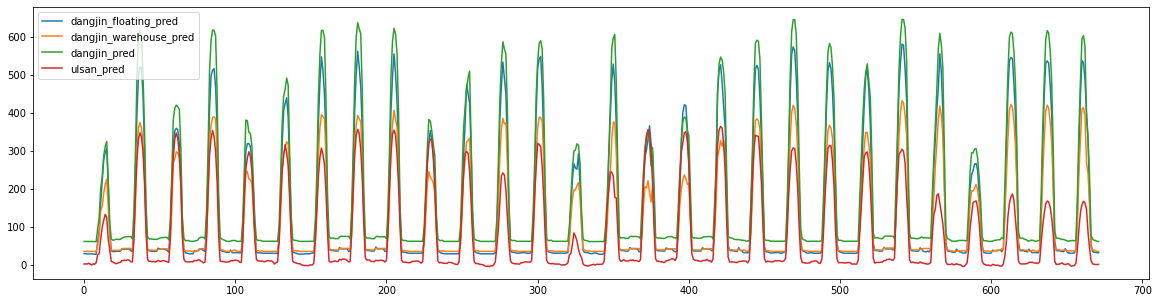

In [125]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

## 제출

In [126]:
submission = pd.read_csv('data/sample_submission.csv')

In [127]:
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred
submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred

In [128]:
submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,29.187531,35.072555,61.425032,1.696115
1,2021-02-01 02:00:00,29.156642,35.057686,61.223406,2.325391
2,2021-02-01 03:00:00,28.510886,35.057686,61.223406,1.614029
3,2021-02-01 04:00:00,28.510886,35.057686,61.223406,3.986509
4,2021-02-01 05:00:00,28.510886,35.057686,61.223406,1.774104
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.000000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.000000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.000000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.000000,0.000000,0.000000,0.000000


In [129]:
submission.to_csv('dacon_baseline_add_wind_time_insolation.csv', index=False)
# submission.to_csv('dacon_baseline_time_insolation.csv', index=False)

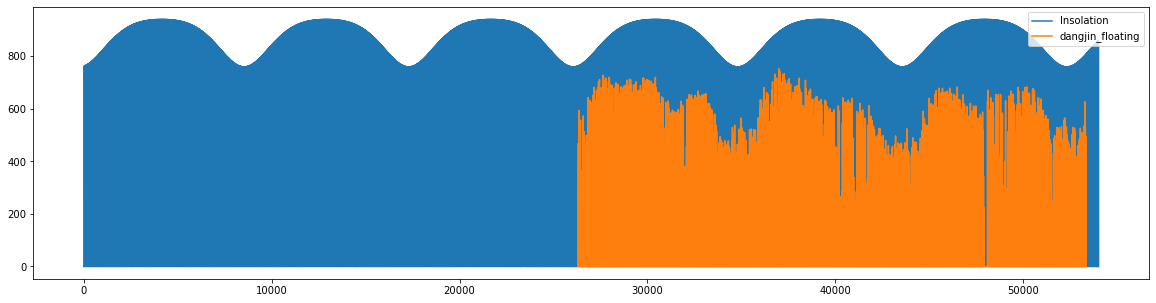

In [130]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_fcst['Insolation'] * 1000, label='Insolation')
plt.plot(energy['dangjin_floating'], label='dangjin_floating')
#plt.plot([declination(i/10) for i in range(3650)], label='true')
plt.legend()
plt.show()

In [131]:
# 일기 예보 있는 날짜만 선택
energy_ = energy.loc[24:]
energy_.index = range(energy_.shape[0])

# 발전량 데이터가 있는 날짜만 선택
dangjin_fcst_ = dangjin_fcst.loc[:25608-1]
dangjin_fcst_.index = range(dangjin_fcst_.shape[0])

# 예보 시간 및 날짜 정보 feature로 추가
dangjin_fcst_['date'] = dangjin_fcst_['Forecast_time'].str.split(' ').str[0]
dangjin_fcst_['hour'] = dangjin_fcst_['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)

dangjin_fcst_['year'] = dangjin_fcst_['date'].str.split('-').str[0].astype(int)
dangjin_fcst_['month'] = dangjin_fcst_['date'].str.split('-').str[1].astype(int)
dangjin_fcst_['day'] = dangjin_fcst_['date'].str.split('-').str[2].astype(int)

# 발전량과 일기예보 연결
heat_df = pd.concat([energy_, dangjin_fcst_], axis=1)
heat_df = heat_df[[ #'month', 'hour', 'day', 'hour',
                    #'Year sin', 'Year cos', 'Day sin', 'Day cos',
                    'Temperature', 'Humidity', 
                    'WindSpeed', 'WindDirection',
                    'Wind_X', 'Wind_Y',
                    'Insolation',
                    'Cloud',
                    'dangjin']]

D:\Anaconda\envs\data_engeneering\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\Anaconda\envs\data_engeneering\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda\envs\data_engeneering\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [132]:
heat_corr = heat_df.corr()

<AxesSubplot:>

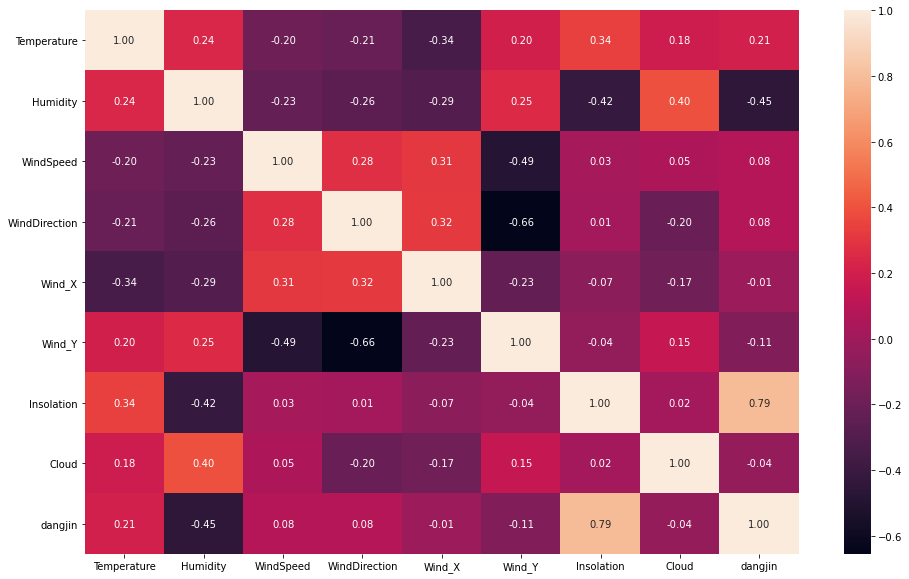

In [133]:
plt.figure(figsize=(16,10))
sns.heatmap(data = heat_corr, annot=True, fmt = '.2f')